In [1]:
import scipy
from scipy import io
import cvxpy as cp
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

### Exercise 3

**(a) Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.**

First of all we load the file that define the network.

In [2]:
file = scipy.io.loadmat('capacities.mat')
capacities = file.get('capacities')
capacities = capacities.reshape(28,)

file = scipy.io.loadmat('traveltime.mat')
traveltime = file.get('traveltime')
traveltime = traveltime.reshape(28,)

file = scipy.io.loadmat('flow.mat')
flow = file.get('flow')
flow = flow.reshape(28,)

# B, the node-link incidence matrix
# each row corresponds to a node, we have 17 nodes
# each column corresponds to a link, we have 28 edges
file = scipy.io.loadmat('traffic.mat')
traffic = file.get('traffic') 

In [3]:
print("capacities shape: ", np.shape(capacities))
#print("capacities: ", capacities)
print("traveltime shape: ", np.shape(traveltime))
print("flow shape: ", np.shape(flow))
print("traffic shape: ", np.shape(traffic))

capacities shape:  (28,)
traveltime shape:  (28,)
flow shape:  (28,)
traffic shape:  (17, 28)


We built a graph G stating from the node-link incidence matrix. We take the transpose and we iterate over every row, which is the link, and over every column, which is the node. Every time we find a couple of (+1, -1) we identify and edge taking the value of the 2 nodes and we can add it to the graph, labeling with the number of row which indicate the number of link.

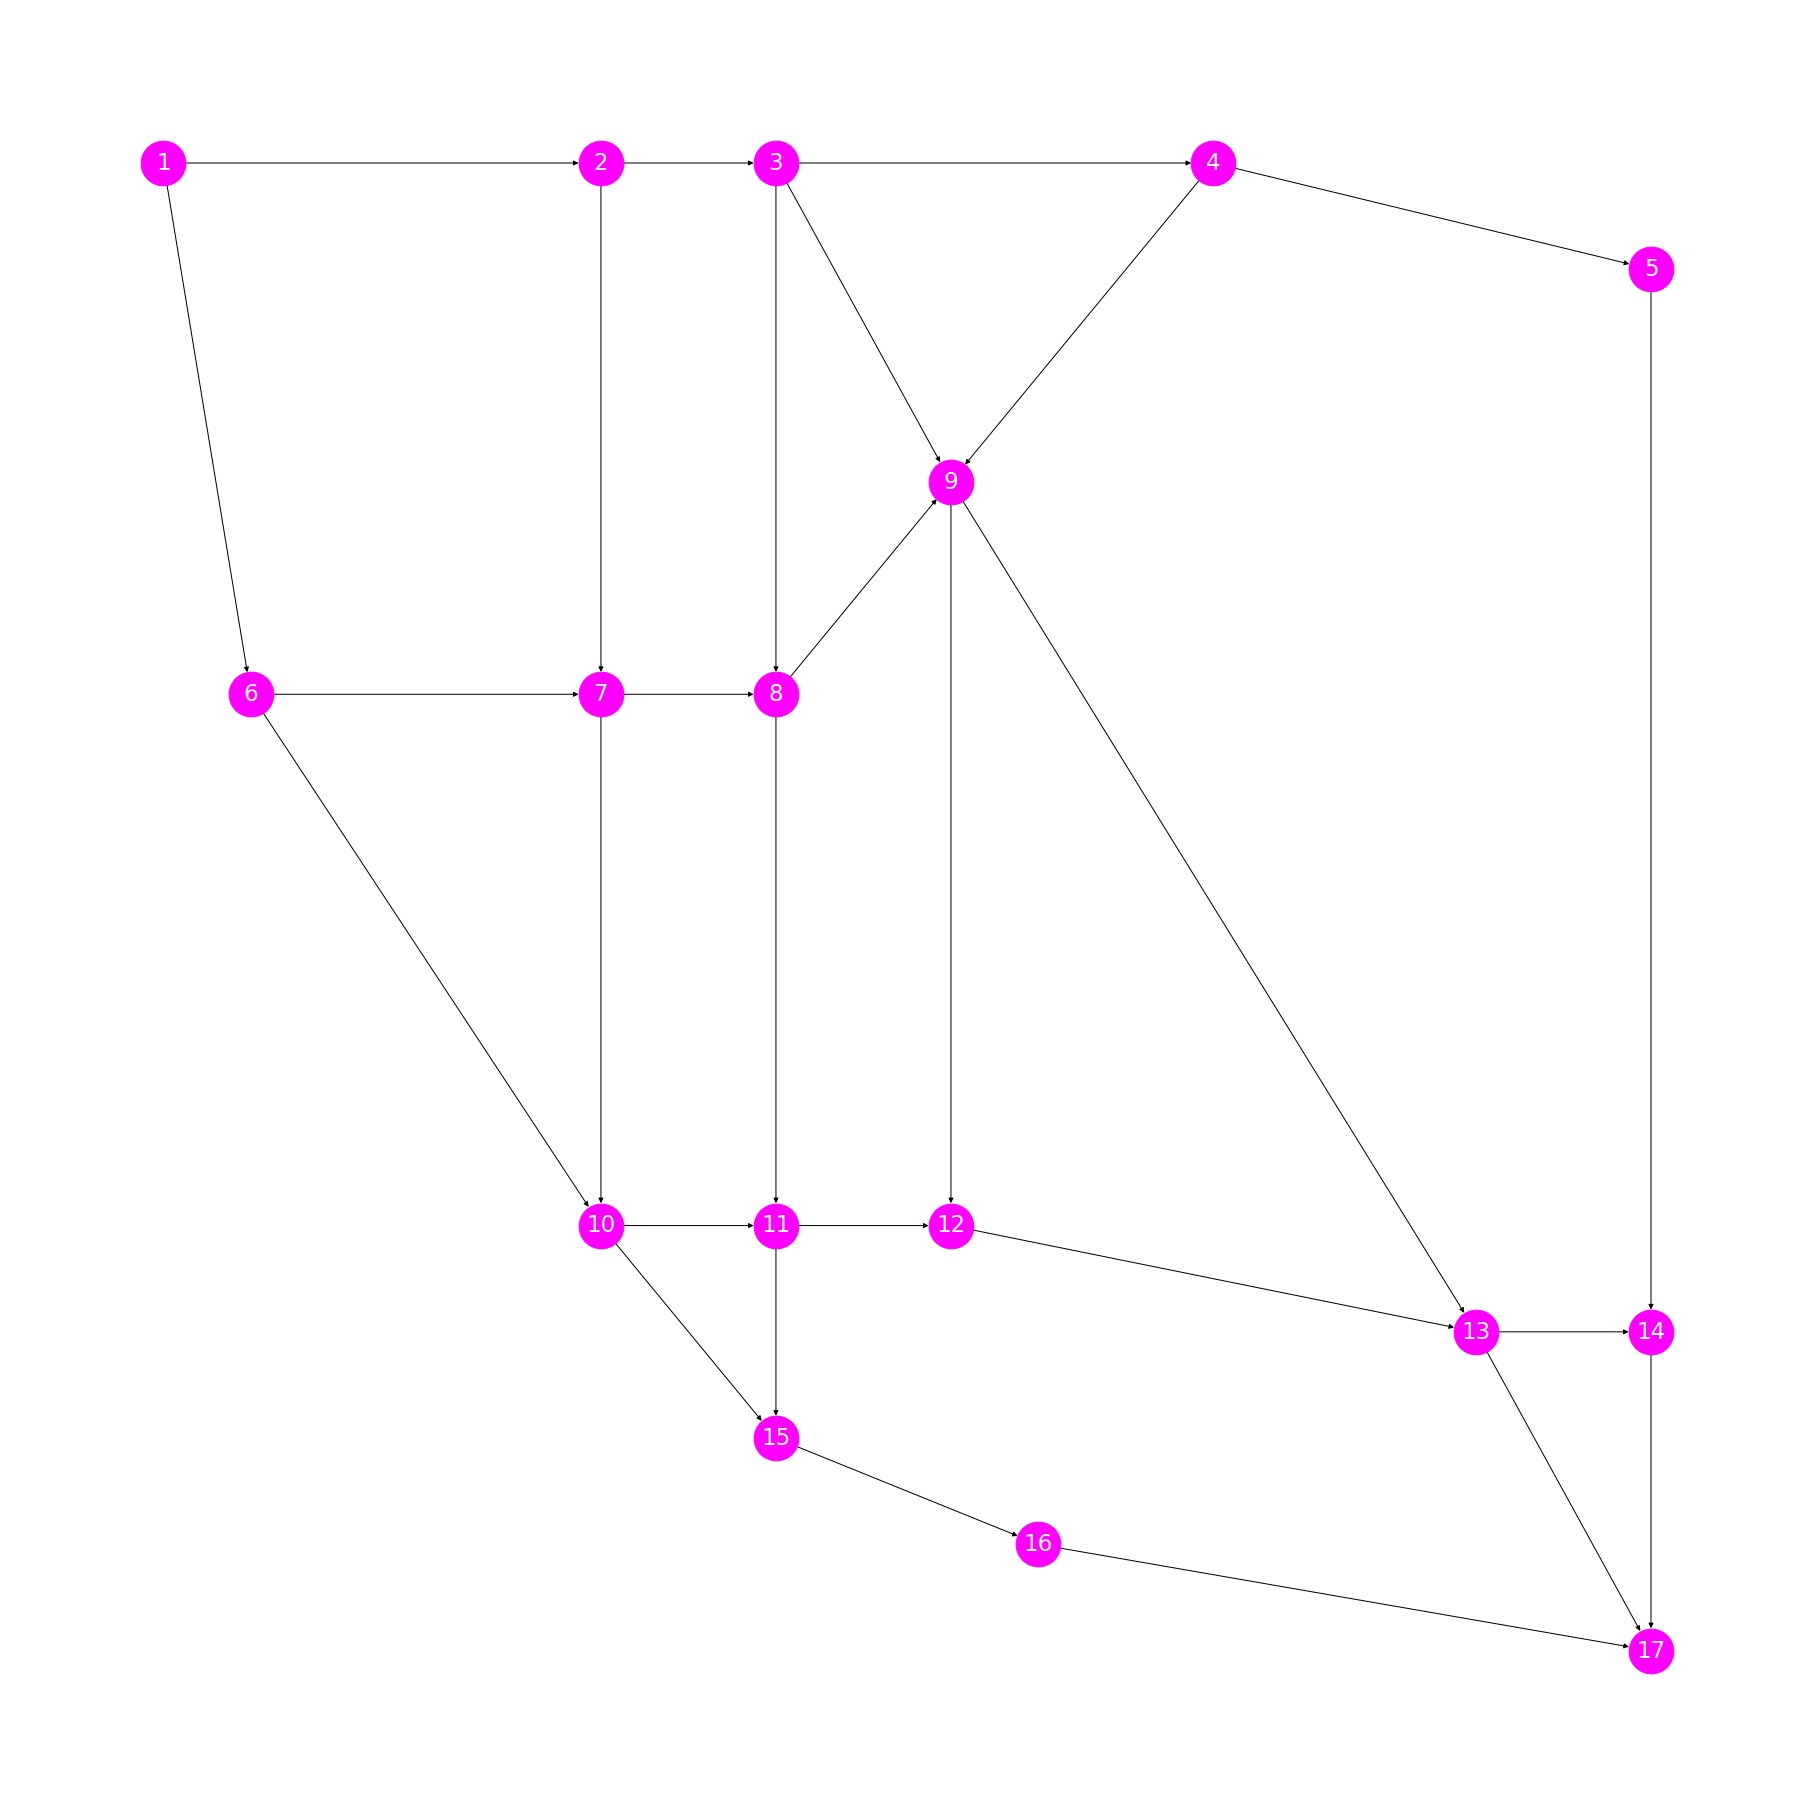

In [4]:
fig = plt.figure(1, figsize=(25,25))

edges = np.shape(traffic.T)[0]
nodes = np.shape(traffic.T)[1]

G = nx.DiGraph()

# for each row, which represent an edge
for i in range(0, edges):
    # for rach column, which represent a node
    for j in range(0, nodes):
        # +1 represents the tail of the edge
        if(traffic.T[i][j]==1):
            tail = j+1    
        # -1 represents the head of the edge
        if(traffic.T[i][j]==-1):
            head = j+1
            # in this matrix -1 is always after +1, so if I find -1 I can add the edge to the graph.
            # I assign the capacity related to the edge from the capacity array.
            # I do the same also for flow and travel time.
            G.add_edges_from([(tail, head)], capacity = capacities[i])
            G[tail][head]['flow'] = flow[i]
            G[tail][head]['traveltime'] = traveltime[i]
            G[tail][head]['label'] = i+1
            
            
pos = {1:[0,15], 2:[5,15], 3:[7,15], 4:[12,15], 5:[17,14],
       6:[1,10], 7:[5,10], 8:[7,10], 9:[9,12], 10:[5,5],
       11:[7,5], 12:[9,5], 13:[15,4], 14:[17,4],15:[7,3],
       16:[10,2], 17:[17,1]
      }       
            
nx.draw(G, pos, with_labels = True, font_color='white', node_color='magenta',  node_size=2000, font_size=23)


To draw the graph with different attribute labels over the edges we define an useful function.

In [5]:
def draw_edge_labels(G, pos, attr):
    for e in G.edges():
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(e[0],e[1]):G[e[0]][e[1]][attr]}, 
                                                           font_size=15, font_color='black')

In [6]:
#print(dict(G.edges))
#print("")
#print("capacities", capacities)  
#print("")
#print("flow", flow) 
#print("")
#print("traveltime", traveltime) 

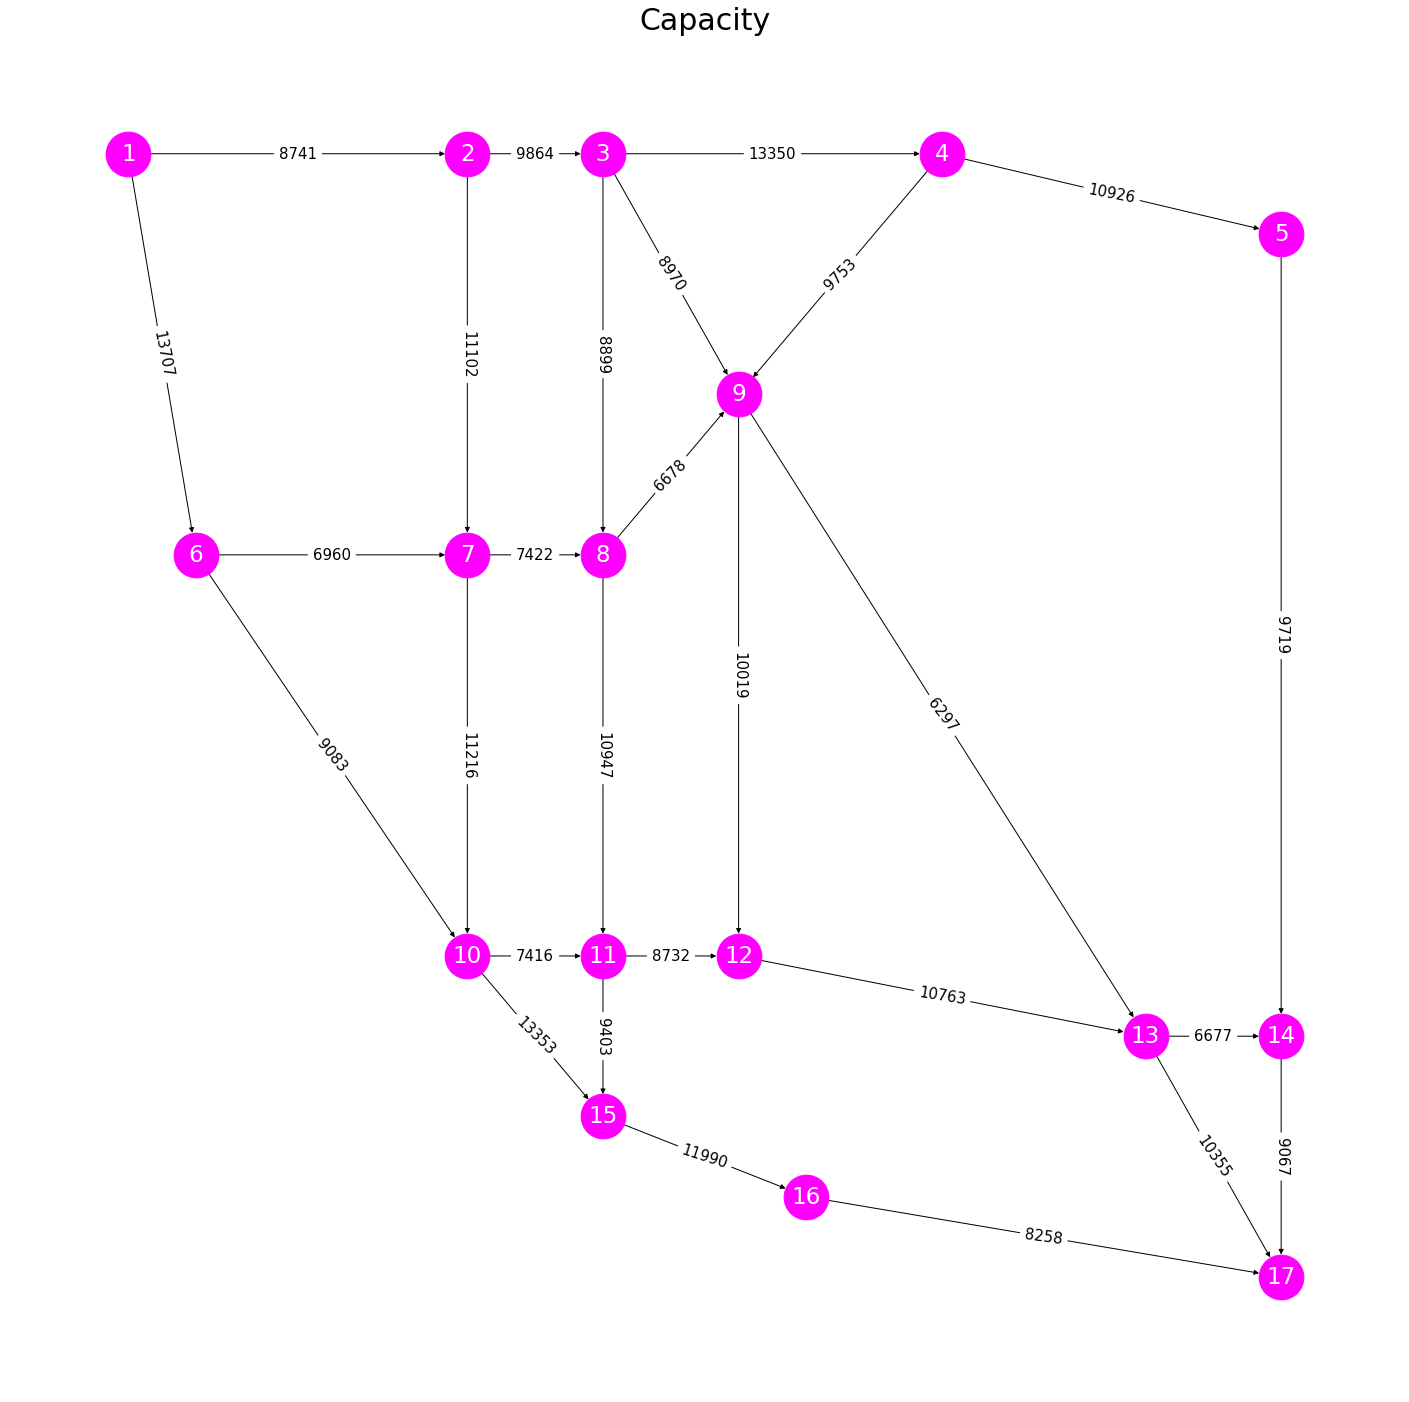

In [7]:
fig = plt.figure(1, figsize=(25,25))
draw_edge_labels(G, pos, 'capacity')
plt.title("Capacity", fontsize = 30)
nx.draw(G, pos, with_labels=True, font_color='white', node_color='magenta', node_size=2000, font_size=23)

In [8]:
print("flow", flow) 

flow [ 7524  6537 11139  9282  9282  6398  6728  5988  5951  9557  7423  7423
  6814  8536  7652  6537 11924  9640  8161  8603  7974  9446  5562  6719
  9455  6686 10833  7403]


In [9]:
fig = plt.figure(1, figsize=(25,25))
draw_edge_labels(G, pos, 'flow')
plt.title("Flows", fontsize = 30)
nx.draw(G, pos, with_labels=True, font_color='black', node_color='lightgreen', node_size=2000, font_size=23)

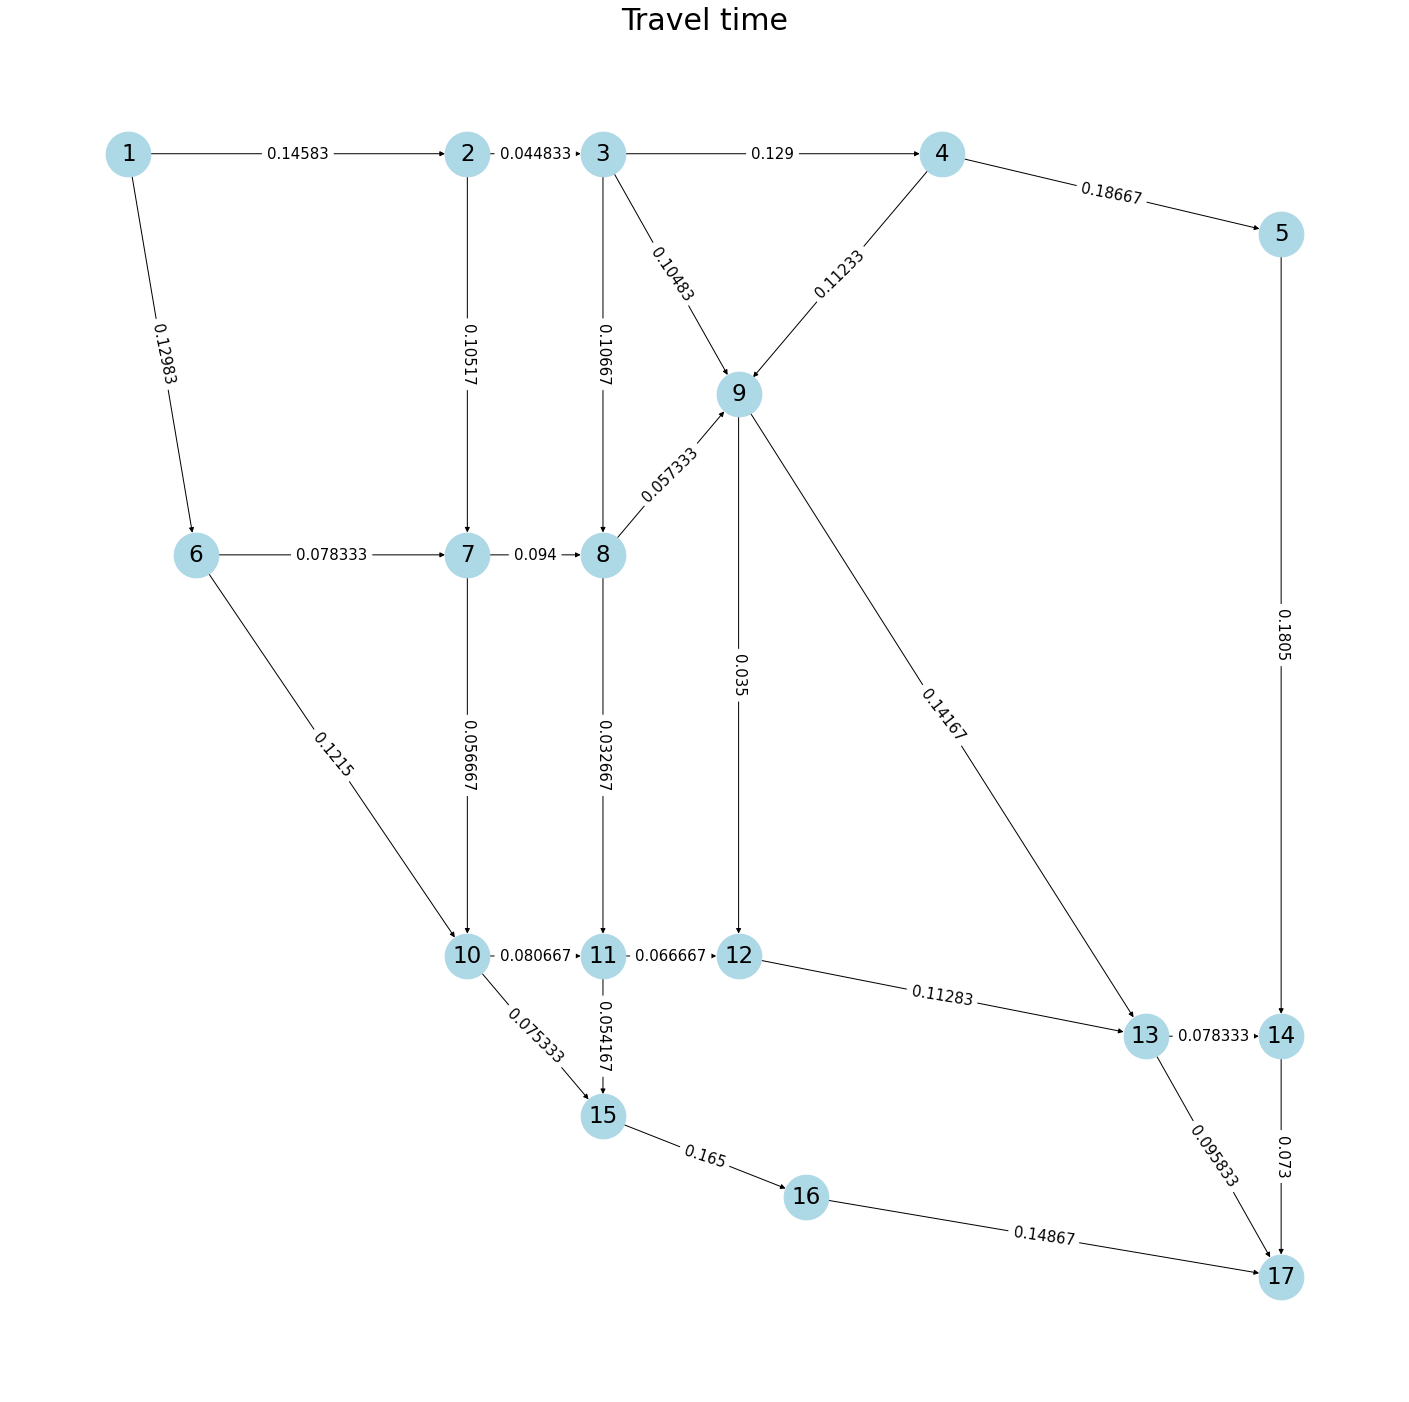

In [10]:
fig = plt.figure(1, figsize=(25,25))
draw_edge_labels(G, pos, 'traveltime')
plt.title("Travel time", fontsize = 30)
nx.draw(G, pos, with_labels=True, font_color='black', node_color='lightblue', node_size=2000, font_size=23)

Now we need to find the shortest path.

The shortest path is the path with the shortest traveling time in an empty network (so with flow 0) between the source and the destination given. 

In [11]:
print("Shortest path between node 1 and node 17:")
print(nx.algorithms.shortest_paths.generic.shortest_path(G, source=1, target=17, weight='traveltime'))

Shortest path between node 1 and node 17:
[1, 2, 3, 9, 13, 17]


**(b) Find the maximum flow between node 1 and 17.**

In [12]:
print("Maximum flow between node 1 and node 17:")
print(nx.algorithms.flow.maximum_flow(G, 1, 17, capacity='capacity'))
print("")
print("Minimum cut with origin 1 and destination 17:")
print(nx.algorithms.flow.minimum_cut(G, 1, 17, capacity='capacity'))

Maximum flow between node 1 and node 17:
(22448, {1: {2: 8741, 6: 13707}, 2: {3: 8741, 7: 0}, 3: {4: 0, 8: 0, 9: 8741}, 4: {5: 0, 9: 0}, 5: {14: 0}, 6: {7: 4624, 10: 9083}, 7: {8: 4624, 10: 0}, 8: {9: 4624, 11: 0}, 9: {13: 6297, 12: 7068}, 13: {14: 3835, 17: 10355}, 14: {17: 3835}, 10: {11: 825, 15: 8258}, 11: {12: 825, 15: 0}, 15: {16: 8258}, 12: {13: 7893}, 17: {}, 16: {17: 8258}})

Minimum cut with origin 1 and destination 17:
(22448, ({1}, {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}))


**(c) Given the flow vector in flow.mat, compute the external inflow $\nu$ satisfying $Bf = \nu$.**

We need to understand what is the external exogenous flow to add to node 1 in order to satisfy the conservation of mass in the network.

In [13]:
inflow = traffic @ flow
inflow

array([ 16806,   8570,  19448,   4957,   -746,   4768,    413,     -2,
        -5671,   1169,     -5,  -7131,   -380,  -7412,  -7810,  -3430,
       -23544], dtype=int32)

**In the following, we assume that the exogenous inflow is zero in all the nodes except for node 1,
for which  $\nu_1$ has the same value computed in the point (c), and node 17, for which  $\nu_{17}$ = $-\nu_1$**

In [15]:
n_edges = traffic.shape[1]
print(n_edges)
# exogenous flow vector
nu = np.array([inflow[0], 
               0,0,0,0,0,
               0,0,0,0,0,
               0,0,0,0,0,
               -inflow[0]])
nu

28


array([ 16806,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
       -16806])

We first need to define the **delay function $d_e(f_e)$ on a given edge e**, which is:

$$d_e(f_e) = \frac{l_e}{1-f_e/C_e} $$

the **lenght $l_e$ of the edge e** divided by 1 - the fraction of the **flow $f_e$ on that edge** and the **capacity $C_e$ on that edge**.

We compute the **cost function** $\psi_e(f_e)$ (also known as **objective function**), which is defined as:

\begin{equation}
	\sum_{e \in E} \psi_e(f_e) = f_e d_e(f_e)
\end{equation}

the total sum on every edge of the **flow on that edge $f_e$** times the **delay on that edge $d_e(f_e)$**.

In [23]:
l = traveltime 
C = capacities

In [28]:
f = cp.Variable(n_edges)

cost_function = sum(cp.multiply(cp.multiply(l, C), cp.inv_pos(1-(f/C))) - cp.multiply(l, C))

objective = cp.Minimize(cost_function)

constraints = [traffic @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

cost_opt = prob.solve()

opt_flow = f.value
print("Social Optimal flow:", opt_flow)
print("")
print("Social Optimal cost:", cost_opt)

Social Optimal flow: [6.64224888e+03 6.05899056e+03 3.13242555e+03 3.13242547e+03
 1.01637511e+04 4.63836582e+03 3.00633556e+03 2.54256194e+03
 3.13155344e+03 5.83258318e+02 2.99992819e-04 2.92656471e+03
 7.99489623e-05 3.13242547e+03 5.52538530e+03 2.85425773e+03
 4.88641615e+03 2.21528858e+03 4.63773922e+02 2.33757329e+03
 3.31803156e+03 5.65560485e+03 2.37308058e+03 9.37240667e-05
 6.41407770e+03 5.50550606e+03 4.88641624e+03 4.88641624e+03]

Social Optimal cost: 25943.620897517143


In [18]:
nu

array([ 16806,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
       -16806])

In [19]:
f = cp.Variable(n_edges)
#l stores the coefficients of the linear terms of the objective function, in this case the travel time of the links.
# objective = cp.Minimize(l.T @ f)
objective = cp.Minimize(traveltime.T @ f)
constraints = [traffic @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)
# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()
# The optimal value for f is stored in `f.value`.
opt_flow = f.value
print("Optimal f:", opt_flow)
print("Optimal cost:", cost_opt)

Optimal f: [1.68060000e+04 1.68060000e+04 2.18717448e-06 9.88521788e-07
 2.17203101e-05 1.97990732e-05 1.34726632e-05 6.62660816e-06
 1.68059997e+04 1.56684423e-06 3.86566086e-06 1.68060000e+04
 1.19865300e-06 9.88521898e-07 1.92123696e-06 8.60488201e-06
 1.20960926e-06 7.89325428e-06 1.07117160e-05 2.88137220e-04
 1.70776707e-05 3.05214891e-04 6.59643540e-06 2.23892732e-06
 1.68060000e+04 7.58495720e-06 3.44853638e-06 3.44853629e-06]
Optimal cost: 8957.530780911127


In [20]:
m1 = np.array([[2, 5],[8,9]])
m2 = np.array([[1, 2],[3,4]])
print(cp.inv_pos(m1))

power([[2. 5.]
 [8. 9.]], -1.0)


In [21]:
for i, e in enumerate(test.T):
    print(i, e)

NameError: name 'test' is not defined

In [ ]:
f = cp.Variable(n_edges)

#objective = cp.Minimize(sum( ((l.T @ C) / (1-sum(f/C))) - l.T @ C ))
#objective = cp.Minimize(sum( (l.T @ f) / (1-sum(f/C)) ))

#cost_function = [((l[e]*C[e])/(1-sum(f[e]/C[e]))) - l[e]*C[e] for e in range(len(G.edges()))] 
#objective = cp.Minimize(sum( ((l.T @ C) / (1-sum(f/C))) - l.T @ C ))

#cost_function = cp.sum(cp.multiply(l, f))
#cost_function = sum([((l[e]*C[e])/(1-(f[e]/C[e]))) - l[e]*C[e] for e in range(len(G.edges()))])
#cost_function = sum([cp.multiply((l[e]*C[e]),1/(1-(f[e]/C[e]))) - l[e]*C[e] for e in range(len(G.edges()))])

#cost_function = sum((l.T @ f) / (1 - ( f @ cp.inv_pos(C) )) )

#cost_function = sum(  cp.inv_pos(1-(f/C)) ) # better



cost_function = sum( cp.inv_pos(1-(f/C)) )
cost_function = sum( ((l.T @ C) * cp.inv_pos(1-(f/C))) - (l.T @ C) ) 
#print(cost_function)


objective = cp.Minimize(cost_function)

#constraints = [traffic @ f == nu, f >=0]
constraints = [traffic @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

cost_opt = prob.solve(verbose=True)

opt_flow = f.value
print("Optimal f:", opt_flow)
print(cost_opt)